# Transformer from scratch

This notebook builds a simple Transformer from scratch (Multi-Head Attention, Scaled Dot-Product Attention and Causal Masking included) in tensorflow.

It's made to understand how every part of the Transformer works and how they fit together.

The Transformer is then tested on a simple seq2seq task: translating sentences from English to French.

<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-21.png" width="300">

**Steps :**
1. [Preparing the data](#Preparing-the-data)
2. [Building the Transformer](#Building-the-Transformer)
3. [Training the Transformer](#Training-the-Transformer)
4. [Testing the Transformer](#Testing-the-Transformer)
    
*[Credits and stuff](#Credits-and-stuff)*

In [1]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import re
import numpy as np

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "AVAILABLE" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.9.0

GPU is AVAILABLE


# Preparing the data

## Parsing the file

In [3]:
# parse the file
path = "/kaggle/input"
path = path if os.path.exists(path) else ".{}".format(path)

text_file = os.path.join(path, "fra-eng", "fra.txt")
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
data = []
for line in lines:
    english, french = line.split("\t")
    french = "[start] " + french + " [end]"
    data.append((english, french))

# display a few random samples just to get an idea of the data
for i in range(5):
    print(data[random.randint(0, len(data))])

("I think I'm a pretty good singer.", '[start] Je pense que je suis un assez bon chanteur. [end]')
("I don't see the relevance.", "[start] Je n'en vois pas la pertinence. [end]")
('Mary is the most beautiful girl I know.', '[start] Mary est la plus belle fille que je connaisse. [end]')
('They all speak French.', '[start] Ils parlent tous français. [end]')
('How many people are in your crew?', '[start] Combien de gens compte ton équipage ? [end]')


## Shuffling the data and splitting it into train, validation, and test sets:

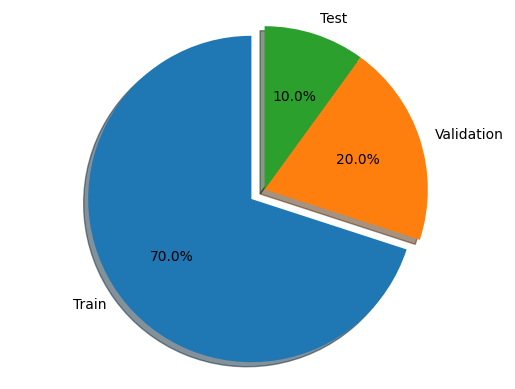

In [4]:
# shuffle the data
random.shuffle(data)

# split the data into train, validation, and test sets
train = data[:int(len(data)*0.7)]
validation = data[int(len(data)*0.7):int(len(data)*0.9)]
test = data[int(len(data)*0.9):]

# display the data sets representations using a pie chart just to see the distribution of the data
labels = 'Train', 'Validation', 'Test'
sizes = [len(train), len(validation), len(test)]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

## Vectorizing the data

This step takes our raw text data and converts it in a format that can be used by our model.

To keep things simple, we will first limit our vocabulary using the **max_tokens** parameter. We will also limit the length of each sample using the **sequence_length** parameter.

Each sample (text input) will be standardize, tokenize by word, and then indexed by token.

This will result in a matrix of vectors (input IDs) of shape (batch_size, **sequence_length**).

In [5]:
max_tokens = 15000
sequence_length = 20

# convert to lowercase and strip all punctuations except "[" and "]", so we can tell apart the words "start" and "end" from the tokens "[start]" and "[end]"
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
 
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")
 
source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # we generate our target sentences that have one extra token, since we’ll need to offset the sentence by one step during training
    standardize=custom_standardization,
)
train_source_texts = [text[0] for text in train]
train_target_texts = [text[1] for text in train]
source_vectorization.adapt(train_source_texts)
target_vectorization.adapt(train_target_texts)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-03-07 19:48:09.489135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-07 19:48:09.489274: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-07 19:48:21.034486: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-07 19:48:21.079792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-07 19:48:36.854610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [6]:
# display a random sample before and after vectorization just to test the vectorization
random_sample = random.randint(0, len(train))
print("Source texts (one random sample):", train_source_texts[random_sample])
print("Target texts (one random sample):", train_target_texts[random_sample])
print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))

# display the decoding of the vectorized text (from vector back to text) just to test the vectorization
source_decoded_text = ''
for i in range(len(source_vectorization(train_source_texts[random_sample]))):
    source_decoded_text += source_vectorization.get_vocabulary()[source_vectorization(train_source_texts[random_sample])[i]] + ' '
print("Source decoded texts (one random sample):", source_decoded_text)

target_decoded_text = ''
for i in range(len(target_vectorization(train_target_texts[random_sample]))):
    target_decoded_text += target_vectorization.get_vocabulary()[target_vectorization(train_target_texts[random_sample])[i]] + ' '
print("Target decoded texts (one random sample):", target_decoded_text)

Source texts (one random sample): China is the biggest country in Asia.
Target texts (one random sample): [start] La Chine est le plus grand pays d'Asie. [end]
Source vectors (one random sample): tf.Tensor(
[1293    7    5 2228  510   15 3785    0    0    0    0    0    0    0
    0    0    0    0    0    0], shape=(20,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[    2    10  1505    15    11    32   258   504 11005     3     0     0
     0     0     0     0     0     0     0     0     0], shape=(21,), dtype=int64)
Source decoded texts (one random sample): china is the biggest country in asia              
Target decoded texts (one random sample): [start] la chine est le plus grand pays dasie [end]            


In [7]:
# display the shape of our vectorized data
train_source_vectors = source_vectorization(train_source_texts)
train_target_vectors = target_vectorization(train_target_texts)
print("Source vectors (shape):", train_source_vectors.shape)
print("Target vectors (shape):", train_target_vectors.shape)

Source vectors (shape): (116990, 20)
Target vectors (shape): (116990, 21)


# Building the Transformer

## Embedding and Position Encoding

This step takes our matrix of vectors (input IDs) of shape (batch_size, sequence_length) and embeds it while adding positional information.

Each vector will be embedded in a low-dimensional floating-point vectors (the dimensionality of the embedding space is defined by the **embedding_size** parameter).

Each embedding vector will then be augmented with positional information.

This will result in a matrix of shape (batch_size, sequence_length, **embedding_size**).

In [8]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = tf.keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [9]:
# display the shape of our embedded data just to test the class

embed_dim = 256

train_source_embedded = PositionalEmbedding(
    sequence_length=sequence_length,
    input_dim=max_tokens,
    output_dim=embed_dim,
    name="source_embedding",
) (train_source_vectors)

train_target_embedded = PositionalEmbedding(
    sequence_length=sequence_length,
    input_dim=max_tokens,
    output_dim=embed_dim,
    name="target_embedding",
) (train_source_vectors)

print("Source embedded vectors (shape):", train_source_embedded.shape)
print("Target embedded vectors (shape):", train_target_embedded.shape)

Source embedded vectors (shape): (116990, 20, 256)
Target embedded vectors (shape): (116990, 20, 256)


## The Attention mechanism

A simple implementation of a Transformer's attention mechanism from scratch.

In practice, we could just use **tf.keras.layers.MultiHeadAttention** instead of building it from scratch. 😒

### Scaled Dot-Product Attention

The scaled dot product attention is calculated as follows :

***Attention(Q, K, V) = softmax(QK^T / √(d_k))V***

Where Q, K, V are the query, key, and value matrices and d_k is the dimensionality of the key matrix.

<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-19.png" width="100">

In [10]:
def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def attention_mask(nd, ns, *, dtype):
    """1's in the lower triangle, counting from the lower right corner.
    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)

def mask_attn_weights(w):
    # w has shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst.
    _, _, nd, ns = shape_list(w)
    b = attention_mask(nd, ns, dtype=w.dtype)
    b = tf.reshape(b, [1, 1, nd, ns])
    w = w*b - tf.cast(1e10, w.dtype)*(1-b)
    return w
    
def scaled_dot_product_attention(q, k, v, use_causal_mask=False):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) # Matmul of Q and K
    scaled_scores = scores / tf.math.sqrt(d_k) # Scale
    if use_causal_mask:
        scaled_scores = mask_attn_weights(scaled_scores) # Mask (opt.)
    weights = tf.nn.softmax(scaled_scores, axis=-1) # SoftMax
    outputs = tf.matmul(weights, v) # Matmul of SoftMax and V
    return outputs

In [11]:
# display the shape of our attention output just to test the function
input = train_source_embedded
input = tf.expand_dims(input, axis=1)
print("Scaled dot product attention (shape):", scaled_dot_product_attention(input, input, input, use_causal_mask=True).shape)

Scaled dot product attention (shape): (116990, 1, 20, 256)


In [12]:
# display the masking of a random tensor just to test the function
random_tensor = tf.random.uniform(shape=(1, 1, 5, 5), minval=0, maxval=1, dtype=tf.float32)
print("Masked attention weights:", mask_attn_weights(random_tensor))

Masked attention weights: tf.Tensor(
[[[[ 3.1179297e-01 -1.0000000e+10 -1.0000000e+10 -1.0000000e+10
    -1.0000000e+10]
   [ 3.9065111e-01  2.9263055e-01 -1.0000000e+10 -1.0000000e+10
    -1.0000000e+10]
   [ 1.6466296e-01  1.3445711e-01  1.3229859e-01 -1.0000000e+10
    -1.0000000e+10]
   [ 5.0970507e-01  4.8252344e-01  1.5580535e-01  3.7032270e-01
    -1.0000000e+10]
   [ 5.6701601e-01  2.0770860e-01  1.8223882e-01  9.9883735e-01
     3.6950588e-01]]]], shape=(1, 1, 5, 5), dtype=float32)


### Multi-Head Attention


The multi-head attention is calculated as follows :

***MultiHead(Q, K, V) = Concat(head_1, ..., head_h)W^O***

Where head_i is the i-th attention head, W^O is the output matrix, and h is the number of attention heads.
    
<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-20.png" width="200">

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.query_dense = tf.keras.layers.Dense(embed_dim)
        self.key_dense = tf.keras.layers.Dense(embed_dim)
        self.value_dense = tf.keras.layers.Dense(embed_dim)
        self.combine_heads = tf.keras.layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, shape=(batch_size, -1, self.num_heads, self.embed_dim // self.num_heads))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def concat_heads(self, x, batch_size):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.embed_dim))

    def call(self, q, k, v, use_causal_mask=False):
        batch_size = tf.shape(k)[0]
        q = self.query_dense(q)
        k = self.key_dense(k)
        v = self.value_dense(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        a = scaled_dot_product_attention(q, k, v, use_causal_mask)
        a = self.concat_heads(a, batch_size)
        c = self.combine_heads(a)
        return c

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "num_heads": self.num_heads,
            "embed_dim": self.embed_dim,
        })
        return config

## The Encoder

<img src="https://raw.githubusercontent.com/renaudjmathieu/notebooks/main/images/chapter03_encoder-zoom.png" width="400">

In the Encoder's Multi-Head Self-Attention layer ([Global self-attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_global_self_attention_layer)), the Encoder's input is passed to all three parameters : **Q**uery, **K**ey, and **V**alue.

In [14]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, dense_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.global_self_attention = MultiHeadAttention(num_heads=num_heads, embed_dim=embed_dim)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        
    def call(self, x):
        # Post layer normalization
        x = self.layer_norm_1(x + self.global_self_attention(x, x, x))
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_heads": self.num_heads,
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
        })
        return config

## The Decoder

<img src="https://raw.githubusercontent.com/renaudjmathieu/notebooks/main/images/chapter03_decoder-zoom.png" width="500">

In the Decoder's Masked Multi-Head Self-Attention layer ([Causal self-attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_causal_self_attention_layer)), the Decoder's input is passed to all three parameters : **Q**uery, **K**ey, and **V**alue.

In the Decoder’s Encoder-Decoder Attention layer ([Cross attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_cross_attention_layer)), the outputs of the Encoder stack are passed to the **K**ey and **V**alue parameters, with the intermediate representations of the Decoder being passed to the **Q**uery parameter.

In [15]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, dense_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.causal_self_attention = MultiHeadAttention(num_heads=num_heads, embed_dim=embed_dim)
        self.cross_attention = MultiHeadAttention(num_heads=num_heads, embed_dim=embed_dim)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.layer_norm_3 = tf.keras.layers.LayerNormalization()

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_heads": self.num_heads,
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
        })
        return config

    def call(self, x, context):
        # Post layer normalization
        x = self.layer_norm_1(x + self.causal_self_attention(x, x, x, use_causal_mask=True))
        x = self.layer_norm_2(x + self.cross_attention(q=x, k=context, v=context))
        x = self.layer_norm_3(x + self.feed_forward(x))
        return x

## Putting it all together

<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-21.png" width="300">

In [16]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="source")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(num_heads, embed_dim, dense_dim)(x)

decoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="target")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(decoder_inputs)
x = TransformerDecoder(num_heads, embed_dim, dense_dim)(x, encoder_outputs)
x = tf.keras.layers.Dropout(0.5)(x)
decoder_outputs = tf.keras.layers.Dense(max_tokens, activation="softmax")(x)

transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Training the Transformer

## Preparing the datasets

We create our input pipeline using the **tf.data** API.

In [17]:
batch_size = 64

def format_dataset(source, target):
    source = source_vectorization(source)
    target = target_vectorization(target)
    return ({
        "source": source,
        "target": target[:, :-1],
    }, target[:, 1:])

def make_dataset(texts):
    source_texts, target_texts = zip(*texts)
    source_texts = list(source_texts)
    target_texts = list(target_texts)
    dataset = tf.data.Dataset.from_tensor_slices((source_texts, target_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train)
validation_ds = make_dataset(validation)

In [18]:
#display the shape of the first batch of data in the dataset just to see what it looks like
for batch in train_ds.take(1):
    print("Source shape:", batch[0]["source"].shape)
    print("Target shape:", batch[0]["target"].shape)
    print("Target shape:", batch[1].shape)

Source shape: (64, 20)
Target shape: (64, 20)
Target shape: (64, 20)


2023-03-07 19:48:43.699059: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Starting the training

In [19]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

EPOCHS = 3
checkpoint_filepath = '/tmp/checkpoint/'
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),
]
    
transformer.fit(train_ds, 
                epochs=EPOCHS, 
                callbacks=callbacks_list,
                validation_data=validation_ds)

transformer.load_weights(checkpoint_filepath)

Epoch 1/3


2023-03-07 19:48:45.359501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1828/1828 [==============================] - ETA: 0s - loss: 1.4969 - accuracy: 0.7890

2023-03-07 19:51:15.631176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1828/1828 [==============================] - 175s 94ms/step - loss: 1.4969 - accuracy: 0.7890 - val_loss: 1.0712 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 2/3
1828/1828 [==============================] - 166s 91ms/step - loss: 1.0768 - accuracy: 0.8442 - val_loss: 0.9618 - val_accuracy: 0.8552 - lr: 0.0010
Epoch 3/3
1828/1828 [==============================] - 166s 91ms/step - loss: 0.9609 - accuracy: 0.8598 - val_loss: 0.9276 - val_accuracy: 0.8616 - lr: 0.0010


# Testing the Transformer

Let's translate a few random test sentences with our trained Transformer.

In [21]:
target_vocab = target_vectorization.get_vocabulary()
target_index_lookup = dict(zip(range(len(target_vocab)), target_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_source_texts = [text[0] for text in test]
for _ in range(50):
    input_sentence = random.choice(test_source_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Where's the closest restaurant?
[start] où est le restaurant le plus grand [end]
-
That is the duty of the police.
[start] cest le [UNK] de la police [end]
-
We'll be eating soon.
[start] nous nous [UNK] bientôt [end]
-
This is sweet.
[start] cest bon [end]
-
Can I borrow a pen? Mine's on its last legs.
[start] puisje emprunter un grand stylo sur les [UNK]
-
She didn't want him to play poker.
[start] elle ne voulait pas quil jouer au tennis
-
I received a letter from one of my friends in Japan.
[start] jai fait une lettre de mon japon dans
-
I'm not ignoring you.
[start] je ne vous [UNK] pas [end]
-
I'm too tired to concentrate on this problem right now.
[start] je suis trop fatigué pour me rendre à
-
Seal the doors.
[start] [UNK] les [UNK] [end]
-
Tom recommends that you not do that again.
[start] tom vous [UNK] de ne pas ça [end]
-
So, do you like it?
[start] alors le [UNK] [end]
-
Take a chance.
[start] prenez une chance [end]
-
Children should be kept away from the pond.
[start] 

# Credits and stuff

- https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb

- https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb

- https://github.com/karpathy/minGPT/blob/master/mingpt/model.py

- https://github.com/openai/gpt-2/blob/master/src/model.py

- https://arxiv.org/abs/1706.03762

- https://www.tensorflow.org/text/tutorials/transformer

- https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11

- https://www.oreilly.com/library/view/natural-language-processing/9781098136789/ch03.html